In [44]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm
from skimage import io, transform, img_as_ubyte
from skimage.feature import hog, local_binary_pattern, greycomatrix
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from cv2 import calcHist
from copy import deepcopy
from scipy.cluster.vq import *
import matplotlib.pyplot as plt

In [2]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [3]:
DATA_FOLDER = os.path.join(os.getcwd(), 'data')
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'test')
DATA_SIZE = 224

## Train Data

In [4]:
train = []
for category in CATEGORIES:
    filelist = [file for file in os.listdir(os.path.join(TRAIN_FOLDER, category)) if file.endswith('.png')]
    print('{} -> {}'.format(category, len(filelist)))
    for file in filelist:
        train.append([os.path.join(TRAIN_FOLDER, category, file), category, []])
train = pd.DataFrame(train, columns=['path', 'species', 'data'])
print(train.shape)
train.head(2)

Black-grass -> 263
Charlock -> 390
Cleavers -> 287
Common Chickweed -> 611
Common wheat -> 221
Fat Hen -> 475
Loose Silky-bent -> 654
Maize -> 221
Scentless Mayweed -> 516
Shepherds Purse -> 231
Small-flowered Cranesbill -> 496
Sugar beet -> 385
(4750, 3)


,path,species,data
0,C:\Users\s110024\Documents\CV\HW1\data\train\B...,Black-grass,[]
1,C:\Users\s110024\Documents\CV\HW1\data\train\B...,Black-grass,[]


In [5]:
for i, file in tqdm(enumerate(train['path'])):  # 4750 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    img = img_as_ubyte(img)
    train['data'][i] = img

C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(224, 224, 3)


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


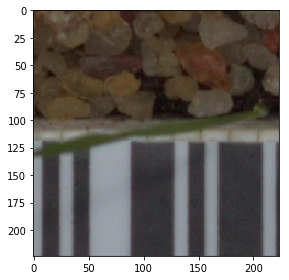

C:\Users\s110024\Documents\CV\HW1\data\train\Black-grass\0050f38b3.png
Black-grass


In [6]:
print(train['data'][0].shape)
io.imshow(train['data'][0])
io.show()
print(train['path'][0])
print(train['species'][0])

## Test Data

In [7]:
test = []
filelist = [file for file in os.listdir(TEST_FOLDER) if file.endswith('.png')]
print('Test -> {}'.format(len(filelist)))
for file in filelist:
    test.append([os.path.join(TEST_FOLDER, file), file, "", []])
test = pd.DataFrame(test, columns=['path', 'file', 'species', 'data'])
print(test.shape)
test.head(2)

Test -> 794
(794, 4)


,path,file,species,data
0,C:\Users\s110024\Documents\CV\HW1\data\test\00...,0021e90e4.png,,[]
1,C:\Users\s110024\Documents\CV\HW1\data\test\00...,003d61042.png,,[]


In [8]:
for i, file in tqdm(enumerate(test['path'])): # 794 in train
    img = io.imread(file)
    img = transform.resize(img, [DATA_SIZE, DATA_SIZE, 3])
    img = img_as_ubyte(img)
    test['data'][i] = img

C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(224, 224, 3)


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


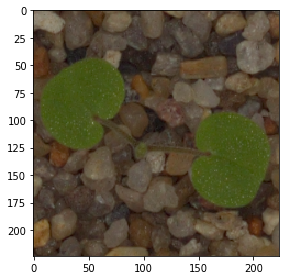

0021e90e4.png


In [9]:
print(test['data'][0].shape)
io.imshow(test['data'][0])
io.show()
print(test['file'][0])

## Raw image

In [ ]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['data'][testID] - train['data'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [ ]:
test[['file', 'species']].to_csv('submission_raw.csv', index=False)

## Using HOG

In [11]:
train['grayscale'] = ""
train['hog_image'] = ""
for i in tqdm(range(len(train))):
    train['grayscale'][i] = img_as_ubyte(rgb2gray(train['data'][i]))
    normalised_blocks, train['hog_image'][i] = hog(train['grayscale'][i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), visualise=True)

C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


TypeError: Image data cannot be converted to float

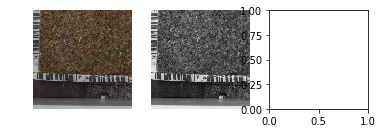

In [13]:
plt.subplot(1,3,1)
plt.imshow(train['data'][10])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train['grayscale'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train['hog_image'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [12]:
test['grayscale'] = ""
test['hog_image'] = ""
for i in tqdm(range(len(test))):
    test['grayscale'][i] = img_as_ubyte(rgb2gray(test['data'][i]))
    normalised_blocks, test['hog_image'][i] = hog(test['grayscale'][i], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8), visualise=True)

C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [ ]:
plt.subplot(1,3,1)
plt.imshow(test['data'][10])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test['grayscale'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test['hog_image'][10], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['hog_image'][testID] - train['hog_image'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [ ]:
test[['file', 'species']].to_csv('submission_HOG.csv', index=False)

## Using Local Binary Pattern

In [ ]:
train['lbp_image'] = ""
for i in tqdm(range(len(train))):
    train['lbp_image'][i] = local_binary_pattern(train['grayscale'][i], P=24, R=8)

In [ ]:
plt.subplot(1,3,1)
plt.imshow(train['data'][20])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(train['grayscale'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(train['lbp_image'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
test['lbp_image'] = ""
for i in tqdm(range(len(test))):
    test['lbp_image'][i] = local_binary_pattern(test['grayscale'][i], P=24, R=8)

In [ ]:
plt.subplot(1,3,1)
plt.imshow(test['data'][20])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(test['grayscale'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test['lbp_image'][20], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
print(test['lbp_image'][20])

In [ ]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['lbp_image'][testID] - train['lbp_image'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [ ]:
test[['file', 'species']].to_csv('submission_LBP.csv', index=False)

In [ ]:
print(train['grayscale'][0])

## Using Co-occurrence Matrix

In [ ]:
train['comatrix'] = ""
for i in tqdm(range(len(train))):
    train['comatrix'][i] = greycomatrix(train['grayscale'][i], distances=[1], angles=[0])

In [ ]:
io.imshow(train['comatrix'][20][:,:,0,0])

In [ ]:
test['comatrix'] = ""
for i in tqdm(range(len(test))):
    test['comatrix'][i] = greycomatrix(test['grayscale'][i], distances=[1], angles=[0])

In [ ]:
io.imshow(test['comatrix'][20][:,:,0,0])

In [ ]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['comatrix'][testID] - train['comatrix'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [ ]:
test[['file', 'species']].to_csv('submission_comatrix.csv', index=False)

## Using Color histogram

In [ ]:
BINS = 256

In [ ]:
train['hist'] = ""
hist = np.zeros([3, BINS, 1])
for i in tqdm(range(len(train))):
    for j in range(0,3):
        hist[j] = calcHist([train['data'][i][:,:,j]], [0], None, [BINS], [0, 256])
    train['hist'][i] = deepcopy(hist)

In [ ]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(train['hist'][100][2])
plt.xlim([0, BINS])
print(train['hist'][100][2].sum())

In [ ]:
test['hist'] = ""
hist = np.zeros([3, BINS, 1])
for i in tqdm(range(len(test))):
    for j in range(0,3):
        hist[j] = calcHist([test['data'][i][:,:,j]], [0], None, [BINS], [0, 256])
    test['hist'][i] = deepcopy(hist)

In [ ]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(test['hist'][100][2])
plt.xlim([0, BINS])
print(train['hist'][100][2].sum())

In [ ]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['hist'][testID] - train['hist'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [ ]:
test[['file', 'species']].to_csv('submission_histogram.csv', index=False)

## Using Gabor Filters

In [ ]:
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [ ]:
train['gabor'] = ""
gabor = np.zeros([len(kernels), 2])
for i in tqdm(range(len(train))):
    gabor = compute_feats(train['grayscale'][i], kernels)
    train['gabor'][i] = deepcopy(gabor)

In [ ]:
test['gabor'] = ""
gabor = np.zeros([len(kernels), 2])
for i in tqdm(range(len(test))):
    gabor = compute_feats(test['grayscale'][i], kernels)
    test['gabor'][i] = deepcopy(gabor)

In [ ]:
for testID in tqdm(range(len(test))):
    minSSD, answerID = -1, -1
    for trainID in range(len(train)):
        distance = test['gabor'][testID] - train['gabor'][trainID]
        SSD = np.sum(distance**2)
        if SSD < minSSD or minSSD == -1:
            minSSD = SSD
            answerID = trainID
    test['species'][testID] = train['species'][answerID]

In [ ]:
plt.subplot(1,3,1)
plt.imshow(train['grayscale'][0], cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(kernels[6], cmap=plt.cm.gray)
#plt.axis('off')

filtered = ndi.convolve(train['grayscale'][0], kernels[6], mode='wrap')
plt.subplot(1,3,3)
plt.imshow(filtered, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [ ]:
test[['file', 'species']].to_csv('submission_gabor.csv', index=False)

## Using Bag-of-Features

In [16]:
# pip install --user opencv-contrib-python==3.3.0.10

sift = cv2.xfeatures2d.SIFT_create()

In [51]:
des_list = []
for i in tqdm(range(len(train))):
    (kps, descs) = sift.detectAndCompute(train['data'][i], None)
    des_list.append(descs)

In [55]:
descriptors = des_list[0]
for descriptor in tqdm(des_list[1:]):
    descriptors = np.vstack((descriptors, descriptor))  

In [56]:
descriptors.shape

(925569, 128)

In [ ]:
# Perform k-means clustering
k=1024
voc, variance = kmeans(descriptors, k, 1) 

In [ ]:
im_features = np.zeros((len(train), k), "float32")
for i in tqdm(len(train)):
    words, distance = vq(des_list[i], voc)
    for w in words:
        im_features[i][w] += 1